In [1]:
import simulation
import utils
import HminLower
import shannonLower
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import json
import ShannonEAT
import cvxpy as cp
import chaospy

In [6]:
delta, p = simulation.getProbas(sqrt(0.4), 0.77, 1e-6, '1')

In [7]:
shannonLower.runOpti(delta, p, 7/8)

-3.618615952265014
-1.4632242844390695
-0.8158901403356512
-0.5027498195171053
-0.31769921072639
-0.1931067513697288
-0.09904176389566811


np.float64(0.6288711310156483)

In [8]:
m_in = 4
m = int(m_in*2)
distribution = chaospy.Uniform(lower=0, upper=1)
t, w = chaospy.quadrature.radau(m_in,distribution,1.0)
t = t[0]

In [ ]:
H = 0.0
for i in range(m-1):
    ti = t[i]
    taui =  (w[i]/(t[i]*np.log(2)))

    Lambda = cp.Variable((2,2), complex=True)

    Gammas = {}
    for a in range(3):
        Gammas[a] = cp.Variable((2,2), complex = True)

    Deltas = {}
    for a in range(3):
        Deltas[a] = cp.Variable((2,2), complex = True)

    constraints = []

    lambdasbx = {}
    for b in range(3):
        lambdasbx[b] = {}
        for x in range(2):
            lambdasbx[b][x] = cp.Variable()

    As = {}
    for a in range(3):
        As[a] = {}
        for b in range(3):
            As[a][b] = cp.Variable((2,2), complex = True)

    Bs = {}
    for a in range(3):
        Bs[a] = {}
        for b in range(3):
            Bs[a][b] = cp.Variable((2,2), complex = True)

    Cs = {}
    for a in range(3):
        Cs[a] = {}
        for b in range(3):
            Cs[a][b] = cp.Variable((2,2), complex = True)

    for a in range(3):
        for b in range(3):
            Rab = cp.bmat([[As[a][b], Bs[a][b]], 
                        [Bs[a][b].H, Cs[a][b]]])
            constraints += [Rab >> 0]

    rho0 = np.array([[1.,0],[0,0]])
    rho1 = np.array([[delta**2, delta*np.sqrt(1-delta**2)], 
                    [delta*np.sqrt(1-delta**2), 1-delta**2]])
    rho1 = rho1 / np.trace(rho1) #bc of floating errors

    rho = {0: rho0, 1: rho1}

    for a in range(3):
        for b in range(3):
            Sab10 = 2*taui*(a==b)*(1/8*rho[0] + 7/8*rho[1]) + Gammas[a] - 1/2*cp.trace(Gammas[a])*np.eye(2)
            Sab11 = taui * ((1-ti)*(a==b) + ti) * (7/8 * rho[1] + 1/8 * rho[0]) + Deltas[a] - 1/2*cp.trace(Deltas[a])*np.eye(2)
            constraints += [Cs[a][b] == Sab11]
            constraints += [Bs[a][b] + Bs[a][b].H == Sab10]

    constraints += [sum([ As[a][b] for a in range(3) ]) == sum([ lambdasbx[b][x]*rho[x] for x in range(2) ]) + Lambda  for b in range(3)] ##somehow this one works but not with the delta_ab, maybe bc we set 0 which is not good

    sumbx = 0.0
    for b in range(3):
        for x in range(2):
            sumbx += lambdasbx[b][x] * p[b][x]

    obj = cp.real(-cp.trace(Lambda) - sumbx)

    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(solver='MOSEK')
    # for b in range(3):
    #     for x in range(2):
    #         print(lambdasbx[b][x].value)
    prob.value
    H += prob.value
cm = 0.0

for i in range(m-1):
    cm += w[i]/(t[i]*np.log(2))

H += cm
H

np.float64(0.6824459583422628)

In [25]:
p

{0: {0: 0.0, 1: 0.0},
 1: {0: 1e-06, 1: 0.20626132770422323},
 2: {0: 0.999999, 1: 0.7937386722957768}}

In [2]:
delta, p = simulation.doSimul(sqrt(0.3), 7/8, '1', 1000, 0.77)
shannonLower.runOpti(delta, p[0], 7/8)

-3.6206549114678346 (242.03498082981636+0j)
-1.4714614839053541 (460.71319873367867+0j)
-0.8301679843018279 (563.2902165250488+0j)
-0.5191296620300754 (633.9609076072992+0j)
-0.3325770273071529 (592.4546834331531+0j)
-0.20431861774052265 (349.73149070267954+0j)
-0.10551631320338518 (369.5144845354581+0j)


np.float64(0.5553730536081218)

## Recreating results on Shannon

In [ ]:
alphas = np.linspace(0.05, 1, 70)
betas = np.linspace(0.3, 0.9, 70)
vals = np.zeros((70, 70))
res = {'alphas': alphas, 'betas': betas, 'probas': []}

for i in range(70):
    for j in range(70):
        a = (alphas[i], betas[j])
        deltas, p = simulation.getProbas(a, 0.94, 1e-6, '3', False)
        val = shannonLower.runOpti(deltas, p, 1/2, impl=1)
        vals[i,j] = val
        res['probas'].append(p)

res['vals'] = vals
with open("Results/Shannon3.json", 'w') as f:
    json.dump(res, f)

TypeError: Object of type ndarray is not JSON serializable

/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_2749/1070356245.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  top = cm.get_cmap('Blues_r', n_blues)
/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_2749/1070356245.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bottom = cm.get_cmap('Reds', n_reds)


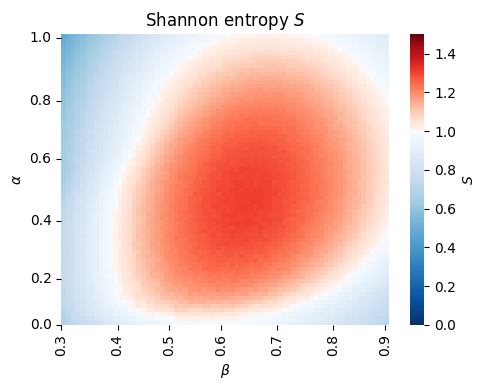

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import cm

# Your custom colormap
n_blues = 400
n_reds = 200
top = cm.get_cmap('Blues_r', n_blues)
bottom = cm.get_cmap('Reds', n_reds)
newcolors = np.vstack((top(np.linspace(0, 1, n_blues)),
                       bottom(np.linspace(0, 1, n_reds))))
newcmp = ListedColormap(newcolors)

# Example data setup (replace with your real data)
# alphas and betas must match vals.shape

# Ticks
alpha_ticks = np.arange(0.0, 1.01, 0.2)
beta_ticks = np.arange(0.3, 0.91, 0.1)
alpha_tick_indices = [np.abs(alphas - a).argmin() for a in alpha_ticks]
beta_tick_indices = [np.abs(betas - b).argmin() for b in beta_ticks]

# Plot
plt.figure(figsize=(5, 4))
ax = sns.heatmap(vals,
                 xticklabels=beta_tick_indices,
                 yticklabels=alpha_tick_indices,
                 cmap=newcmp,             # pass the actual colormap object here!
                 vmin=0.0, vmax=1.5,
                 cbar_kws={'label': '$S$'})

# Tick labels
ax.set_xticks(beta_tick_indices)
ax.set_xticklabels([f"{b:.1f}" for b in beta_ticks])
ax.set_yticks(alpha_tick_indices)
ax.set_yticklabels([f"{a:.1f}" for a in alpha_ticks])
ax.invert_yaxis()

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'Shannon entropy $S$')

plt.tight_layout()
plt.show()


## Comparing Shannon and Hmin -- Same setup as from paper

In [5]:
res1 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '1', False)
    val = shannonLower.runOpti(delta, p, 7/8)

    res1['deltas'].append(delta)
    res1['vals'].append(val)
    res1['probas'].append(p)

with open('Results/Shannon1_077_NoDT.json', 'w') as f:
    json.dump(res1, f)

In [6]:
res2 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '1', True)
    val = shannonLower.runOpti(delta, p, 7/8)

    res2['deltas'].append(delta)
    res2['vals'].append(val)
    res2['probas'].append(p)

with open('Results/Shannon1_077_DT.json', 'w') as f:
    json.dump(res2, f)

In [7]:
res3 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '1', False)
    val = HminLower.getHmin(p, delta, 7/8)

    res3['deltas'].append(delta)
    res3['vals'].append(val)
    res3['probas'].append(p)

with open('Results/Hmin1_077_NoDT.json', 'w') as f:
    json.dump(res3, f)

In [8]:
res4 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '1', True)
    val = HminLower.getHmin(p, delta, 7/8)

    res4['deltas'].append(delta)
    res4['vals'].append(val)
    res4['probas'].append(p)

with open('Results/Hmin1_077_DT.json', 'w') as f:
    json.dump(res4, f)

In [9]:
res5 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 1, 0, '1', False)
    val = shannonLower.runOpti(delta, p, 7/8)

    res5['deltas'].append(delta)
    res5['vals'].append(val)
    res5['probas'].append(p)

with open('Results/Shannon1_1_NoDT.json', 'w') as f:
    json.dump(res5, f)

In [10]:
res6 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 1, 0, '1', False)
    val = HminLower.getHmin(p, delta, 7/8)

    res6['deltas'].append(delta)
    res6['vals'].append(val)
    res6['probas'].append(p)

with open('Results/Hmin1_1_NoDT.json', 'w') as f:
    json.dump(res6, f)

In [11]:
alphas = [sqrt(alpha) for alpha in alphas]

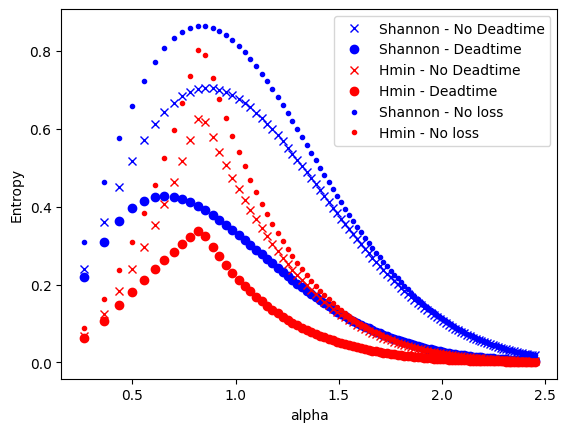

In [12]:
plt.figure()
plt.plot(alphas, res1['vals'], 'bx', label="Shannon - No Deadtime")
plt.plot(alphas, res2['vals'], 'bo', label="Shannon - Deadtime")
plt.plot(alphas, res3['vals'], 'rx', label="Hmin - No Deadtime")
plt.plot(alphas, res4['vals'], 'ro', label="Hmin - Deadtime")
plt.plot(alphas, res5['vals'], 'b.', label="Shannon - No loss")
plt.plot(alphas, res6['vals'], 'r.', label="Hmin - No loss")
plt.xlabel("alpha")
plt.ylabel("Entropy")
plt.legend()

In [13]:
res_1 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '2', False)
    val = shannonLower.runOpti(delta, p, 1/2)

    res_1['deltas'].append(delta)
    res_1['vals'].append(val)
    res_1['probas'].append(p)

with open('Results/Shannon2_077_NoDT.json', 'w') as f:
    json.dump(res_1, f)

In [14]:
res_2 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '2', True)
    val = shannonLower.runOpti(delta, p, 1/2)

    res_2['deltas'].append(delta)
    res_2['vals'].append(val)
    res_2['probas'].append(p)

with open('Results/Shannon2_077_DT.json', 'w') as f:
    json.dump(res_2, f)

In [15]:
res_3 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '2', False)
    val = HminLower.getHmin(p, delta, 1/2)

    res_3['deltas'].append(delta)
    res_3['vals'].append(val)
    res_3['probas'].append(p)

with open('Results/Hmin2_077_NoDT.json', 'w') as f:
    json.dump(res_3, f)

In [16]:
res_4 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '2', True)
    val = HminLower.getHmin(p, delta, 1/2)

    res_4['deltas'].append(delta)
    res_4['vals'].append(val)
    res_4['probas'].append(p)

with open('Results/Hmin2_077_DT.json', 'w') as f:
    json.dump(res_4, f)

In [17]:
res_5 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 1, 0, '2', False)
    val = shannonLower.runOpti(delta, p, 1/2)

    res_5['deltas'].append(delta)
    res_5['vals'].append(val)
    res_5['probas'].append(p)

with open('Results/Shannon2_1_NoDT.json', 'w') as f:
    json.dump(res_5, f)

In [18]:
res_6 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 1, 0, '2', False)
    val = HminLower.getHmin(p, delta, 1/2)

    res_6['deltas'].append(delta)
    res_6['vals'].append(val)
    res_6['probas'].append(p)

with open('Results/Hmin2_1_NoDT.json', 'w') as f:
    json.dump(res_6, f)

In [19]:
alphas = [sqrt(alpha) for alpha in alphas]

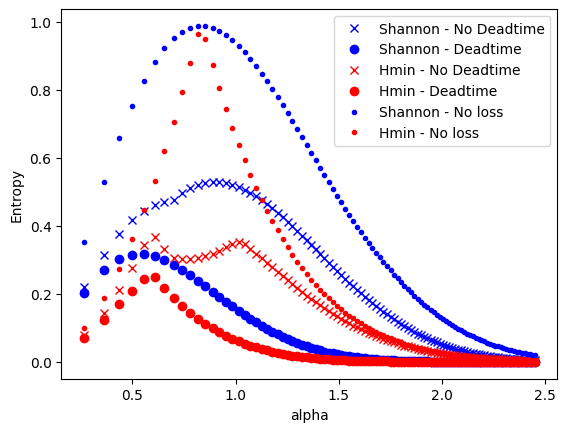

In [20]:
plt.figure()
plt.plot(alphas, res_1['vals'], 'bx', label="Shannon - No Deadtime")
plt.plot(alphas, res_2['vals'], 'bo', label="Shannon - Deadtime")
plt.plot(alphas, res_3['vals'], 'rx', label="Hmin - No Deadtime")
plt.plot(alphas, res_4['vals'], 'ro', label="Hmin - Deadtime")
plt.plot(alphas, res_5['vals'], 'b.', label="Shannon - No loss")
plt.plot(alphas, res_6['vals'], 'r.', label="Hmin - No loss")
plt.xlabel("alpha")
plt.ylabel("Entropy")
plt.legend()

## Comparing Shannon and EAT

In [21]:
res1e3 = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 1000, 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 1000, delta, 7/8)
    res1e3['vals'].append(val)
    res1e3['deltas'].append(delta)

with open('Results/ShannonEAT1_077_NoDT_1e3.json', 'w') as f:
    json.dump(res1e3, f)

In [22]:
res1e4 = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 10000, 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 10000, delta, 7/8)
    res1e4['vals'].append(val)
    res1e4['deltas'].append(delta)

with open('Results/ShannonEAT1_077_NoDT_1e4.json', 'w') as f:
    json.dump(res1e4, f)

In [23]:
res1e5 = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 100000, delta, 7/8)
    res1e5['vals'].append(val)
    res1e5['deltas'].append(delta)

with open('Results/ShannonEAT1_077_NoDT_1e5.json', 'w') as f:
    json.dump(res1e5, f)

In [24]:
res2e3 = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 1000, 0.77, True)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 1000, delta, 7/8)
    res2e3['vals'].append(val)
    res2e3['deltas'].append(delta)

with open('Results/ShannonEAT1_077_DT_1e3.json', 'w') as f:
    json.dump(res2e3, f)

In [25]:
res2e4 = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 10000, 0.77, True)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 10000, delta, 7/8)
    res2e4['vals'].append(val)
    res2e4['deltas'].append(delta)

with open('Results/ShannonEAT1_077_DT_1e4.json', 'w') as f:
    json.dump(res2e4, f)

In [26]:
res2e5 = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 100)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, True)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 100000, delta, 7/8)
    res2e5['vals'].append(val)
    res2e5['deltas'].append(delta)

with open('Results/ShannonEAT1_077_DT_1e5.json', 'w') as f:
    json.dump(res2e5, f)

In [27]:
alphas = [sqrt(alpha) for alpha in alphas]

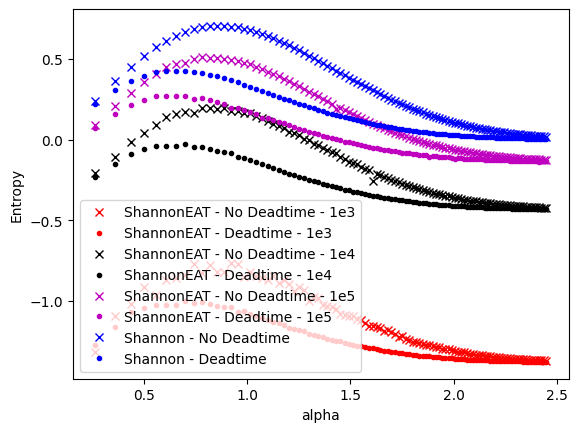

In [28]:
plt.figure()
plt.plot(alphas, res1e3['vals'], 'rx', label='ShannonEAT - No Deadtime - 1e3')
plt.plot(alphas, res2e3['vals'], 'r.', label='ShannonEAT - Deadtime - 1e3')
plt.plot(alphas, res1e4['vals'], 'kx', label='ShannonEAT - No Deadtime - 1e4')
plt.plot(alphas, res2e4['vals'], 'k.', label='ShannonEAT - Deadtime - 1e4')
plt.plot(alphas, res1e5['vals'], 'mx', label='ShannonEAT - No Deadtime - 1e5')
plt.plot(alphas, res2e5['vals'], 'm.', label='ShannonEAT - Deadtime - 1e5')
plt.plot(alphas, res1['vals'], 'bx', label='Shannon - No Deadtime')
plt.plot(alphas, res2['vals'], 'b.', label='Shannon - Deadtime')
plt.xlabel('alpha')
plt.ylabel('Entropy')
plt.legend()

## Choosing a particular point and comparing evolution of EAT with number of samples

In [29]:
alpha = sqrt(0.6)
npoints = np.linspace(3, 7, 10)

delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '1', False)
H_theo = shannonLower.runOpti(delta, p, 7/8)

In [30]:
vals = []
for npoint in npoints:
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', int(10**npoint), 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, int(10**npoint), delta, 7/8)
    vals.append(val)
    

Text(0, 0.5, 'H')

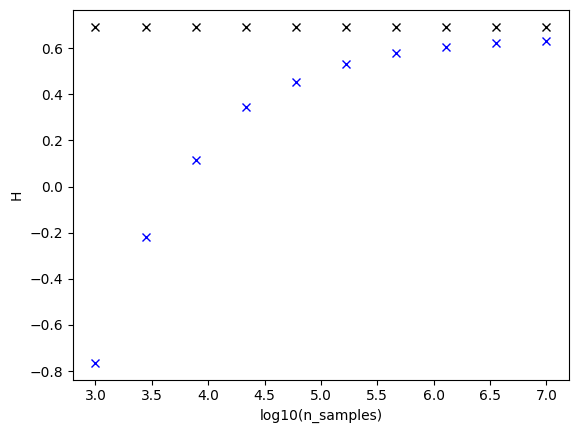

In [31]:
plt.figure()
Hts = [H_theo]*10
plt.plot(npoints, Hts, 'kx')
plt.plot(npoints, vals, 'bx')
plt.xlabel("log10(n_samples)")
plt.ylabel("H")

## Using noisy source

In [32]:
resN0 = {'deltas': [], 'probas': [], 'vals': [], 'amaxs': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    amax, delta, p = simulation.doSimul(alpha, 7/8, '1', 1000000, 1, False, True)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    resN0['deltas'].append(delta)
    resN0['vals'].append(val)
    resN0['probas'].append(p)
    resN0['amaxs'].append(amax)

with open('Results/Shannon1_077_BadS.json', 'w') as f:
    json.dump(resN0, f)

In [33]:
resN1 = {'deltas': [], 'probas': [], 'vals': [], 'amaxs': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    amax, delta, p = simulation.doSimul(alpha, 7/8, '1', 1000000, 0.77, False, True)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    resN1['deltas'].append(delta)
    resN1['vals'].append(val)
    resN1['probas'].append(p)
    resN1['amaxs'].append(amax)

with open('Results/Shannon1_077_BadSNoDT.json', 'w') as f:
    json.dump(resN1, f)

In [34]:
resN2 = {'deltas': [], 'probas': [], 'vals': [], 'amaxs': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha) 
    amax, delta, p = simulation.doSimul(alpha, 7/8, '1', 1000000, 0.77, True, True)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    resN2['deltas'].append(delta)
    resN2['vals'].append(val)
    resN2['probas'].append(p)
    resN2['amaxs'].append(amax)

with open('Results/Shannon1_077_BadSDT.json', 'w') as f:
    json.dump(resN2, f)

In [35]:
res1 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 1, 0, '1', False)
    val = shannonLower.runOpti(delta, p, 7/8)

    res1['deltas'].append(delta)
    res1['vals'].append(val)
    res1['probas'].append(p)

In [36]:
resN3 = {'deltas': [], 'vals': [], 'amaxs': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    amaxs = []
    delta = 0.0
    for i in range(5):
        amax, delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, True, True)
        ps.append(p[0])
        amaxs.append(amax)
    val = ShannonEAT.getH(ps, 100000, delta, 7/8)
    resN3['vals'].append(val)
    resN3['deltas'].append(delta)
    resN3['amaxs'].append(np.mean(amaxs))

with open('Results/Shannon1_077_BadSDT_EAT.json', 'w') as f:
    json.dump(resN3, f)

In [37]:
alphas = [sqrt(alpha) for alpha in alphas]

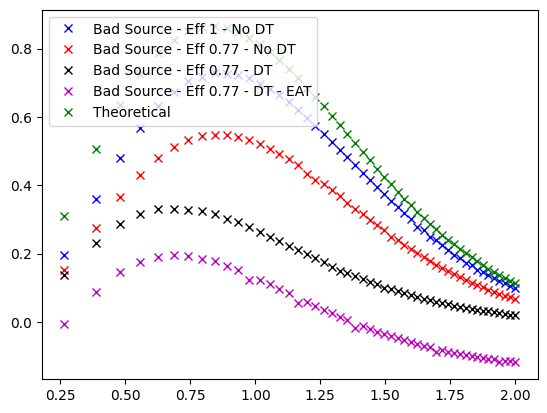

In [38]:
plt.figure()
plt.plot(alphas, resN0['vals'], 'bx', label= 'Bad Source - Eff 1 - No DT')
plt.plot(alphas, resN1['vals'], 'rx', label= 'Bad Source - Eff 0.77 - No DT')
plt.plot(alphas, resN2['vals'], 'kx', label= 'Bad Source - Eff 0.77 - DT')
plt.plot(alphas, resN3['vals'], 'mx', label= 'Bad Source - Eff 0.77 - DT - EAT')
plt.plot(alphas, res1['vals'], 'gx', label= 'Theoretical')
plt.legend(loc='upper left')